In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


X_train, y_train = [], []
X_test, y_test = [], []

image_size = 150

def load_images_from_folder(folder_path, label_index):
    data = []
    labels = []
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading images from {folder_path}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            data.append(img)
            labels.append(label_index)
        else:
            print(f"Failed to load image: {img_path}")
    return data, labels


for label in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Training', label)
    data, label_data = load_images_from_folder(folder_path, labels.index(label))
    X_train.extend(data)
    y_train.extend(label_data)

# تحميل بيانات الاختبار
for label in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Testing', label)
    data, label_data = load_images_from_folder(folder_path, labels.index(label))
    X_test.extend(data)
    y_test.extend(label_data)


X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)


print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution in training data: {dict(zip(unique, counts))}")

Loading images from /kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor: 100%|██████████| 826/826 [00:01<00:00, 480.04it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor: 100%|██████████| 822/822 [00:01<00:00, 477.57it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/no_tumor: 100%|██████████| 395/395 [00:00<00:00, 475.03it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor: 100%|██████████| 827/827 [00:01<00:00, 426.07it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor: 100%|██████████| 100/100 [00:00<00:00, 454.42it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor: 100%|██████████| 115/115 [00:00<00:00, 547.18it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/no_tumor: 100%|██████████| 105/105 [00:00<00:00, 707.30it/s]
Loading images from /kaggle

Training data shape: (2870, 150, 150, 3)
Testing data shape: (394, 150, 150, 3)
Training labels shape: (2870,)
Testing labels shape: (394,)
Class distribution in training data: {0: 826, 1: 822, 2: 395, 3: 827}


In [13]:
y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2296, 150, 150, 3)
Validation data shape: (574, 150, 150, 3)
Test data shape: (394, 150, 150, 3)


In [15]:
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

   
    Flatten(),

    
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout لتقليل احتمالية الإفراط في التعلم (Overfitting)

    
    Dense(len(labels), activation='softmax')  # عدد الفئات = عدد الفئات في التصنيفات
])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,  
    batch_size=32,
    verbose=1
)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.4406 - loss: 1.2654 - val_accuracy: 0.6289 - val_loss: 0.8663
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6694 - loss: 0.8032 - val_accuracy: 0.7195 - val_loss: 0.6340
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7580 - loss: 0.6202 - val_accuracy: 0.8066 - val_loss: 0.4972
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8277 - loss: 0.4270 - val_accuracy: 0.7875 - val_loss: 0.5008
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8434 - loss: 0.3822 - val_accuracy: 0.7944 - val_loss: 0.4554
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8580 - loss: 0.3301 - val_accuracy: 0.8711 - val_loss: 0.3295
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8997 - loss: 0.2559 - val_accuracy: 0.8972 - val_loss: 0.2619
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9359 - loss: 0.1759 - val_accuracy: 0.9024 - v

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5159 - loss: 8.9434
Test Accuracy: 0.72


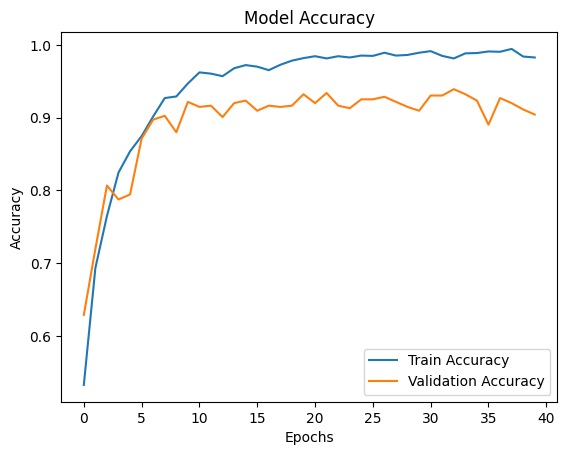

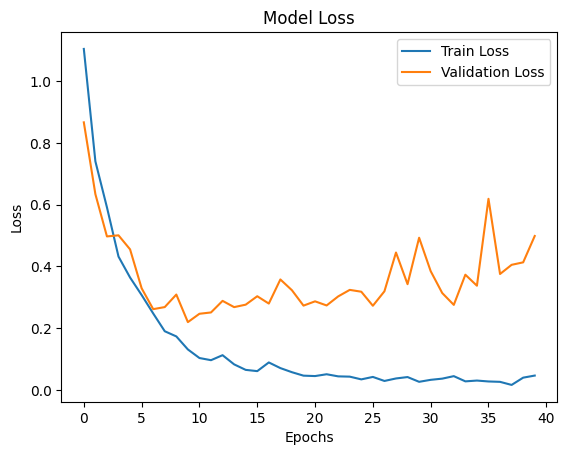

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5159 - loss: 8.9434 
Test Accuracy: 0.72
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.20      0.32       100
        no_tumor       0.84      0.83      0.83       115
meningioma_tumor       0.56      1.00      0.72       105
 pituitary_tumor       0.94      0.88      0.91        74

        accuracy                           0.72       394
       macro avg       0.79      0.73      0.70       394
    weighted avg       0.78      0.72      0.69       394



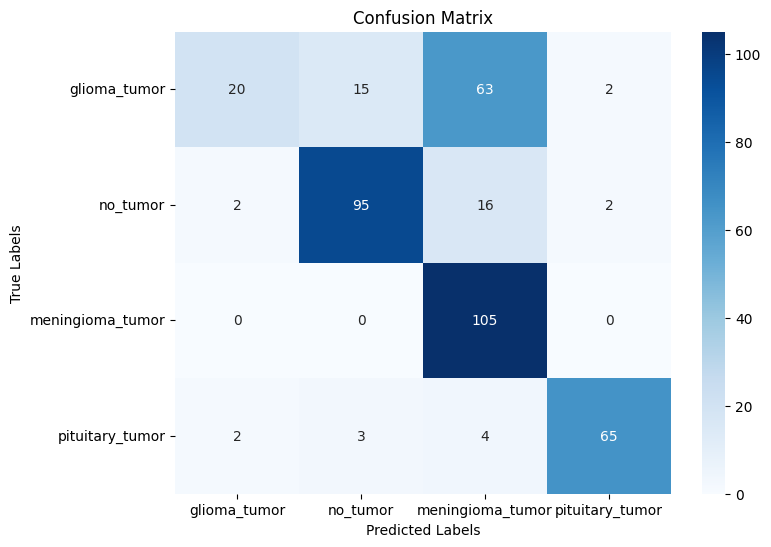

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report (includes precision, recall, F1-score per class)
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
